from walkwith fastai: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Ensembling.ipynb

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [2]:
!pip install -q fastai

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from fastai.tabular.all import *

In [4]:
path = '../input/adult-census-income/adult.csv'
df = pd.read_csv(path)

In [9]:
df.tail()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [7]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [12]:
cat_names = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race','sex','native.country']
cont_names = ['age', 'fnlwgt', 'education.num','hours.per.week']

procs = [Categorify,FillMissing,Normalize]
y_names = 'income'
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

In [13]:
to = TabularPandas(df,procs=procs, cat_names=cat_names,cont_names=cont_names, y_names=y_names,y_block=y_block, splits=splits)

In [15]:
to.show()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,age,fnlwgt,education.num,hours.per.week,income
13597,Local-gov,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,United-States,45.0,182100.0,13.0,40.0,>50K
3119,Private,Assoc-voc,Married-civ-spouse,Tech-support,Husband,White,Male,United-States,52.0,204322.0,11.0,40.0,<=50K
15649,Local-gov,Assoc-acdm,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,33.0,167474.0,12.0,40.0,<=50K
13432,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,Black,Male,United-States,36.0,247750.0,9.0,45.0,<=50K
8723,Private,Assoc-acdm,Divorced,Adm-clerical,Unmarried,White,Female,United-States,42.0,56483.0,12.0,40.0,<=50K
5934,Self-emp-not-inc,11th,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,48.0,104790.0,7.0,50.0,>50K
21461,Private,Bachelors,Divorced,Other-service,Not-in-family,White,Male,United-States,50.0,177705.0,13.0,40.0,<=50K
17520,Private,9th,Separated,Machine-op-inspct,Unmarried,White,Female,Mexico,59.0,230899.0,5.0,40.0,<=50K
22594,Private,Some-college,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,35.0,169672.0,10.0,40.0,<=50K
10315,State-gov,Some-college,Never-married,Adm-clerical,Own-child,White,Female,United-States,35.0,49352.0,10.0,38.0,<=50K


## Using XG Boost

In [16]:
import xgboost as xgb

In [17]:
to.train.ys, to.train.ys.values.ravel() # gives you an array

(       income
 13597       1
 3119        0
 15649       0
 13432       0
 8723        0
 ...       ...
 22233       1
 11970       0
 22514       0
 25631       0
 21637       0
 
 [26049 rows x 1 columns],
 array([1, 0, 0, ..., 0, 0, 0], dtype=int8))

In [18]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [19]:
model = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [21]:
xgb_model = model.fit(X_train, y_train)

In [22]:
xgb_preds = xgb_model.predict_proba(X_test)

In [23]:
xgb_preds

array([[0.9958154 , 0.00418461],
       [0.98843426, 0.01156572],
       [0.2828439 , 0.7171561 ],
       ...,
       [0.9870715 , 0.01292848],
       [0.97074664, 0.02925338],
       [0.97853065, 0.02146937]], dtype=float32)

In [24]:
accuracy(tensor(xgb_preds), tensor(y_test))

tensor(0.8371)

In [25]:
from xgboost import plot_importance

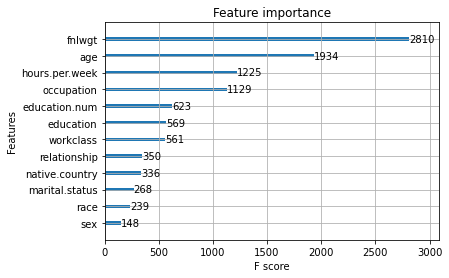

In [26]:
plot_importance(xgb_model)

## Fastai to the fold

In [27]:
dls = to.dataloaders()

In [28]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

In [29]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.372256,0.364452,0.828931,00:07
1,0.355366,0.367456,0.830006,00:07
2,0.349702,0.365403,0.819257,00:07
3,0.328114,0.354054,0.832924,00:08
4,0.346475,0.356127,0.829545,00:07


In [30]:
nn_preds = learn.get_preds()[0]

In [32]:
nn_preds

tensor([[9.9975e-01, 2.5407e-04],
        [9.9972e-01, 2.7879e-04],
        [2.6639e-01, 7.3361e-01],
        ...,
        [9.9971e-01, 2.9388e-04],
        [9.9931e-01, 6.9374e-04],
        [9.9460e-01, 5.3972e-03]])

In [31]:
# from :https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Ensembling.ipynb
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


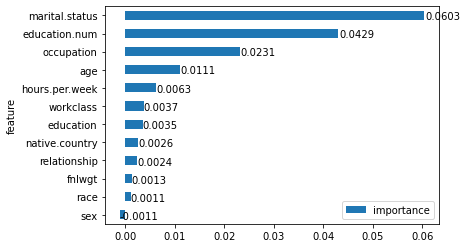

In [33]:
imp = PermutationImportance(learn)

## Ensembling of the two

In [34]:
avgs = (nn_preds + xgb_preds) /2

In [35]:
avgs

tensor([[0.9978, 0.0022],
        [0.9941, 0.0059],
        [0.2746, 0.7254],
        ...,
        [0.9934, 0.0066],
        [0.9850, 0.0150],
        [0.9866, 0.0134]])

In [37]:
argmax = avgs.argmax(dim=1)

In [38]:
argmax

tensor([0, 0, 1,  ..., 0, 0, 0])

In [39]:
accuracy(tensor(nn_preds),tensor(y_test))

tensor(0.8295)

In [40]:
accuracy(tensor(xgb_preds),tensor(y_test))

tensor(0.8371)

In [41]:
accuracy(tensor(avgs),tensor(y_test))

tensor(0.8326)

## Adding Random Forests

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
tree = RandomForestClassifier(n_estimators=100)

In [44]:
tree.fit(X_train,y_train)

RandomForestClassifier()

In [45]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.6-py3-none-any.whl size=10644 sha256=41e7a0aa8f38b232ac845f0d1d8d410da4fa8292a0948efa47639c58c9d0b5b7
  Stored in directory: /root/.cache/pip/wheels/b8/b8/6f/0f09b3a2e372082480b91108b7f1ba415f6446f589a3adef09
Successfully built rfpimp
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [47]:
from rfpimp import *

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [48]:
imp = importances(tree, X_test,to.valid.ys)

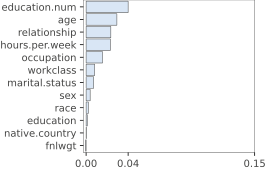

In [49]:
plot_importances(imp)

In [50]:
forest_preds = tree.predict_proba(X_test)

In [51]:
forest_preds

array([[0.99, 0.01],
       [0.99, 0.01],
       [0.16, 0.84],
       ...,
       [0.98, 0.02],
       [0.97, 0.03],
       [0.96, 0.04]])

In [52]:
avgs = (nn_preds+ xgb_preds + forest_preds)/3

In [55]:
accuracy(tensor(forest_preds), tensor(y_test))

tensor(0.8219)

In [53]:
accuracy(tensor(avgs), tensor(y_test))

tensor(0.8334)

Even though accuracy is higher than Random forest alone, it wasn't bigger than neural network. Happy Experimenting!